# Define CBG strata for Population Estimates

In [75]:
from glob import glob
import seaborn as sns
#from statsmodels.stats.power import TTestIndPower
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [76]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [78]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
SJ_RES_PARCELS_FP = os.path.join(PERMIT_INPUT_FP, 'san_jose_parcels_res.geojson')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

# Load data and sources for each year
cbg_sj_2020, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
cbg_sj_2016 = load_bg_shp(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP, year='2016')

TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * CBG income
cbg_income_2016 = gpd.read_file(os.path.join(INPUT_FP, 'cbg_income_2016'))

# * Permits
sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])

# * CF annotations
CF_LABELS = pd.read_csv(os.path.join(OAK_FP, 'CloudFactory/cf_coords.csv'))

[INFO] Restricting zoning data to R-1, R-2 and R-M (ex. R-MH)


100%|██████████| 3324/3324 [00:00<00:00, 15984.91it/s]


In [4]:
# Load inferred buildings for all years and limit to small buildings
building_footprints_infer = {}
for year in ['2016', '2020']:
    building_footprints_infer[year] = gpd.read_file(BUILD_FP.format(year))

small_bfi = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer.items():
    gdf['year'] = year
    small_bfi = pd.concat([small_bfi, gdf])
small_bfi = small_bfi.loc[small_bfi['small'] == 1]

# 1. Strata

## Density of small buildings/parcel across CBGs

In [ ]:
#### ERROR HERE: Need to include parcels with zero small buildings

In [17]:
# Number of buildings/parcel by CBG
# NOTE: this is with no post-processing/permit-matching processing

small_bfi_2016 = small_bfi.loc[small_bfi['year'] == '2016']

cbg_density_path = 'cbg_density.csv'
if not os.path.exists(cbg_density_path):
    cbg_data = pd.DataFrame()
    reviewed_cbgs = []
    
else:
    cbg_data = pd.read_csv(cbg_density_path)
    reviewed_cbgs = cbg_data['GEOID'].to_list()
    print('[INFO] Reviewed cbgs: {}'.format(len(reviewed_cbgs)))
    

for i, cbg_geoid in tqdm(enumerate(cbg_sj_2016['GEOID'].unique())):
    if cbg_geoid in reviewed_cbgs:
        continue
    
    # Only compute for CBGs for which we have income data
    try:
        cbg_income = cbg_income_2016.loc[cbg_income_2016['GEOID'] == int(cbg_geoid)].iloc[0]['mean_income']
    except IndexError:
        cbg_income = None
        continue
    
    # Clip to CBG shp
    cbg_df = cbg_sj_2016.loc[cbg_sj_2016['GEOID'] == cbg_geoid]
    try:
        cbg_sj_parcels_res = gpd.clip(sj_parcels_res, cbg_df)
    except shapely.topology.TopologicalError:
        continue
    cbg_bfi = gpd.clip(small_bfi_2016, cbg_df)
    
    # Assign each building to a single parcel
    n_builds = len(cbg_bfi)
    n_res_parcels = len(cbg_sj_parcels_res)
    
    cbg_sj_parcels_res.reset_index(inplace=True, drop=True)
    cbg_bfi = cbg_bfi.sjoin(cbg_sj_parcels_res[['geometry']], how='left', predicate='intersects')
    cbg_bfi['iou'] = cbg_bfi.apply(
        lambda row: 0 if pd.isnull(row['index_right']) else row['geometry'].intersection(
            cbg_sj_parcels_res.iloc[int(row['index_right'])]['geometry']).area/row['geometry'].area , axis=1)
    cbg_bfi = cbg_bfi[cbg_bfi['iou'] > 0.5]
    
    assert len(cbg_bfi) <= n_builds
    
    # Compute small building density per parcel
    cbg_density = cbg_bfi.groupby('index_right')['small'].count()
    cbg_density = cbg_density.mean()
    
    # Append 
    cbg_dict = {'GEOID': [cbg_geoid], 'density': [cbg_density], 'income': [cbg_income]}
    cbg_data = pd.concat([cbg_data, pd.DataFrame.from_dict(cbg_dict)])
    
    if i % 50 == 0 or i == len(cbg_sj_2016['GEOID'].unique()):
        cbg_data.to_csv(cbg_density_path, index=False)

72it [24:19, 18.30s/it]TopologyException: Input geom 0 is invalid: Self-intersection at -121.953748895847 37.317405249926331
190it [50:54, 10.60s/it]TopologyException: Input geom 0 is invalid: Self-intersection at -121.91844170135776 37.245751715900482
328it [1:36:24, 14.31s/it]TopologyException: Input geom 0 is invalid: Self-intersection at -121.83358410914933 37.248622149170615
546it [2:42:44, 17.05s/it]TopologyException: Input geom 0 is invalid: Self-intersection at -121.84019639503678 37.356544435950781
643it [3:00:29, 16.84s/it]


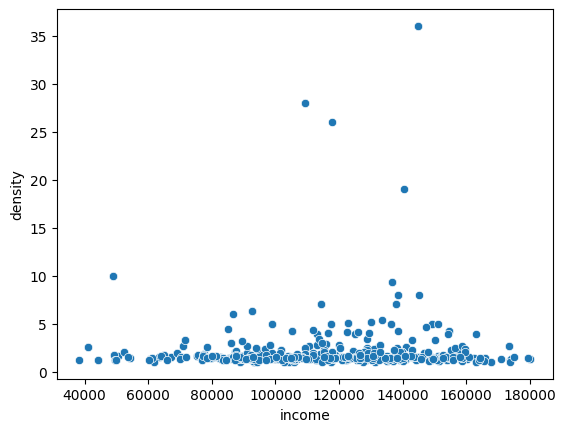

In [18]:
sns.scatterplot(cbg_data, x='income', y='density')
plt.show()

In [19]:
cbg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 0
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GEOID    766 non-null    object 
 1   density  661 non-null    float64
 2   income   764 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.9+ KB


In [21]:
cbg_data['density'].describe()

count    661.000000
mean       2.058309
std        2.882095
min        1.000000
25%        1.307018
50%        1.439024
75%        1.688000
max       36.000000
Name: density, dtype: float64

## Check random tiles for CBGs across income strata

In [91]:
# Assign tiles to CBGs
tile_cbgs = assign_cbgs_by_coverage(tiles_gdf['2020'], cbg_sj_2020)

100%|██████████| 7265/7265 [00:10<00:00, 680.17it/s]


In [92]:
tile_cbgs.head()

,index_left,GEOID,file,geometry
3060,15461,060855062043,m_3712142_ne_10_060_20200525_264,"POLYGON ((-121.80144 37.33855, -121.80144 37.3..."
2293,15363,060855058004,m_3712150_ne_10_060_20200525_202,"POLYGON ((-121.80825 37.22194, -121.80825 37.2..."
2724,18962,060855050143,m_3712150_nw_10_060_20200525_431,"POLYGON ((-121.84005 37.19115, -121.84005 37.1..."
1814,18955,060855050152,m_3712150_nw_10_060_20200525_407,"POLYGON ((-121.85385 37.19406, -121.85385 37.1..."
1594,18933,060855032203,m_3712150_nw_10_060_20200525_124,"POLYGON ((-121.86365 37.23292, -121.86365 37.2..."


In [ ]:
# Select CBGs to visualize
cbg_data.sort_values('income')



In [ ]:
_ = tile_gdf.to_crs('EPSG:26910').file.progress_apply(lambda file: visualize_tile_predvOSM_CF(
        tile_bounds_dict=tile_bounds_dict_all['2020'], # Use tile bounds from 2020
        building_footprints_infer=building_footprints_infer[year], # Use predictions for specific year
        building_footprints_osm=building_footprints_osm,
        file_name=file,
        img_fp=IMG_FP[year], # Use npy arrays for specific year
        tif_fp=TIF_FP['2020'], # Use tile bounds from 2020
        final_output_fp=None,
        save=False, small=True, 
        year=year))

# 2. Confidence Bins

### Generate shapefile of parcels which should/should not have small buildings in 2016

In [54]:
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [24]:
case_dict = load_ground_truth_parcels()
ps_gt_grid = case_dict['Positive small build']
ns_gt_grid = case_dict['Negative small build']

In [60]:
# Generate shapefiles
sj_parcels_res.loc[sj_parcels_res['APN'].isin(ps_gt_grid[0])][['APN', 'geometry']].to_file(
    os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'confidence-bins', 'no_small_build_2016'))

sj_parcels_res.loc[sj_parcels_res['APN'].isin(ns_gt_grid[0])][['APN', 'geometry']].to_file(
    os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'confidence-bins', 'yes_small_build_2016'))

## Design confidence metric

In [13]:
parcel_confidence(
    parcel_apn='27406055', 
    model_params={'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0})

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


0.6898606873002828

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


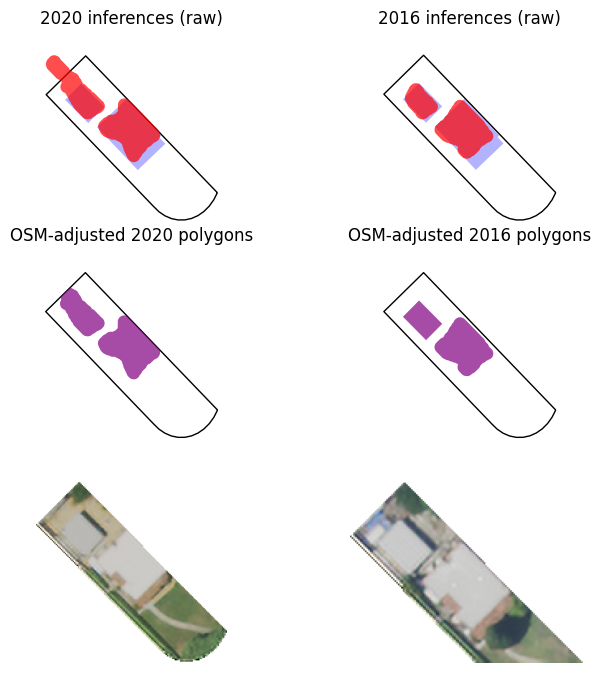

{'2016':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.718582   
 1               False      True          0.783990   
 
                                             geometry        area  
 0  POLYGON ((-121.93137 37.33550, -121.93137 37.3...  124.242556  
 1  POLYGON ((-121.93147 37.33558, -121.93142 37.3...   47.968386  ,
 '2020':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.776121   
 2               False     False          0.595731   
 
                                             geometry        area  
 0  POLYGON ((-121.93137 37.33552, -121.93137 37.3...  131.002692  
 2  POLYGON ((-121.93145 37.33565, -121.93145 37.3...   72.249888  }

In [12]:
plot_processed_parcel(
    parcel_apn='27406055', 
    model_params={'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0},
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
                 'tiles_gdf': tiles_gdf})

## Use CF annotations

In [5]:
model_params = {'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0}

In [6]:
CF_LABELS['year'].unique()

array([2016, 2018, 2020])

In [7]:
CF_LABELS.head()

,latitude,longitude,year,label
0,37.347625,-121.875469,2016,model_found_building
1,37.346976,-121.874903,2016,model_found_building
2,37.347096,-121.874989,2016,model_found_building
3,37.348262,-121.874701,2016,model_found_building
4,37.346881,-121.877431,2016,model_found_building


In [8]:
# Convert to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

## Compute building and parcel-level confidences for CF-annotated parcels

In [9]:
# Need to get universe of parcels that CF annotated 
# * Collect tile names
CF_tiles = []
for cf_round in [1, 2]:
    round_path = os.path.join(
        OAK_FP, 'outputs/Temporal-Error-Analysis/Round{}/CF_Visualizations/2018'.format(cf_round))
    round_tiles = glob.glob(os.path.join(round_path, '*.png'))
    round_tiles = [tile.split(os.path.sep)[-1].replace('-small_2018.png', '') for tile in round_tiles]
    CF_tiles.extend(round_tiles)

In [10]:
# * Collect associated parcels
CF_area_coverage = tiles_gdf['2020'].copy()
CF_area_coverage = CF_area_coverage.loc[CF_area_coverage['file'].isin(CF_tiles)]
#CF_area_coverage = CF_area_coverage.geometry.unary_union

In [11]:
CF_parcels = sj_parcels_res.sjoin(CF_area_coverage, how='left', predicate='intersects')
CF_parcels = CF_parcels.loc[~CF_parcels['index_right'].isna()]

In [12]:
# CF annotated 18,798 parcels in total, for three years. 
# Sample 1000 parcels
np.random.seed(2)
CF_parcels = CF_parcels.iloc[np.random.choice(range(len(CF_parcels)), size=1000, replace=False)]

In [13]:
# Compute confidence for each CF parcel
if os.path.exists('POP-builds-2020'):
    CF_parcel_conf = pd.read_csv('POP-parcel-conf.csv')
    CF_buildings = {'2016': gpd.read_file('POP-builds-2016'), '2020': gpd.read_file('POP-builds-2020')}
    reviewed_parcels = CF_buildings['2020']['APN'].unique()
    print('[INFO] Number of reviewed parcels: {}'.format(len(reviewed_parcels)))
else:
    CF_parcel_conf = pd.DataFrame()
    CF_buildings = {'2016': gpd.GeoDataFrame(geometry=[]), '2020': gpd.GeoDataFrame(geometry=[])}
    reviewed_parcels = []

for i, parcel_apn in tqdm(enumerate(CF_parcels['APN'].unique())):
    if parcel_apn in reviewed_parcels:
        continue
    
    parcel_conf, parcel_build = parcel_confidence(parcel_apn, model_params)
    
    CF_parcel_conf = pd.concat([CF_parcel_conf, pd.DataFrame.from_dict(
        {'APN': [parcel_apn], 'confidence': [parcel_conf]})])
    
    for year in ['2016', '2020']:
        if parcel_build[year] is not None:
            parcel_build[year]['APN'] = parcel_apn
            CF_buildings[year] = pd.concat([CF_buildings[year], parcel_build[year]])
            
    if i % 50 == 0 or i == len(CF_parcels['APN'].unique()):
        CF_parcel_conf.to_csv('POP-parcel-conf.csv', index=False)
        for year in ['2016', '2020']:
            CF_buildings[year].to_file('POP-builds-{}'.format(year))

[INFO] Number of reviewed parcels: 864


997it [03:41,  4.50it/s]


## Building-level confidence

In [14]:
CF_buildings = {}
for year in ['2016', '2020']:
    CF_buildings[year] = gpd.read_file('POP-builds-{}'.format(year))

In [15]:
# Get building-level precision
for year in ['2016', '2020']:
    builds = CF_buildings[year].copy()
    cf_labels = CF_LABELS.loc[CF_LABELS['year'] == int(year)].copy()
    
    # Filter for small buildings (have to use area here as well)
    builds = builds.loc[builds['main_build'] == '0']
    
    builds = builds.loc[builds['area'] < 130]
    
    # Join with CF annotations
    builds = builds.sjoin(cf_labels[['geometry']], how='left', predicate='intersects')
    
    # Assin building level-ground truth variable
    builds['true_positive'] = ~builds['index_right'].isna()
    
    CF_buildings[year] = builds

In [21]:
# Bin by confidence and compute average precision
avg_precision = {}

for year in ['2016', '2020']:
    builds = CF_buildings[year]
    
    builds['bin'] = pd.cut(builds['build_conf'], bins=3, labels=False)
    
    CF_buildings[year] = builds
    
    avg_precision[year] = builds.groupby('bin')['true_positive', 'build_conf'].mean().reset_index()

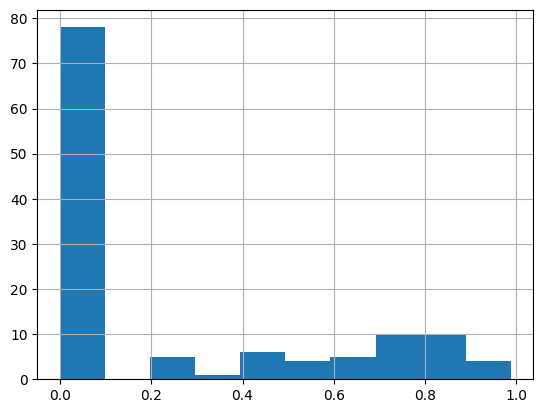

In [22]:
# Confidence histograms
CF_buildings['2020']['build_conf'].hist(bins=10)
plt.show()

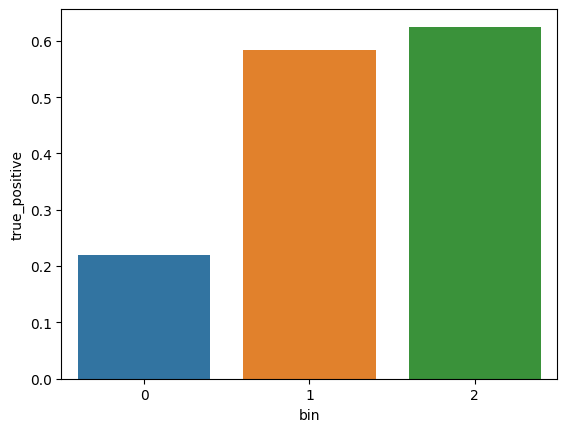

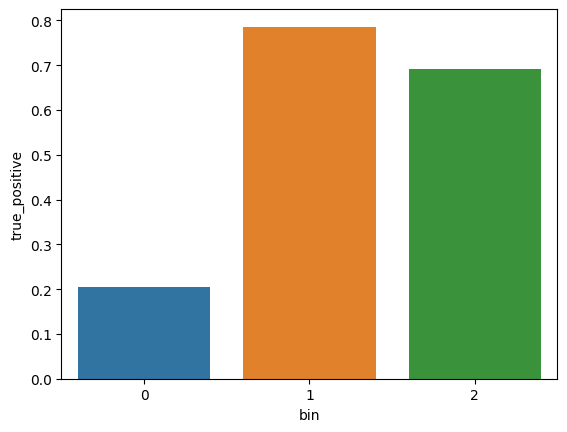

In [23]:
# Plot average precision
for year in ['2016', '2020']:
    sns.barplot(avg_precision[year], x='bin', y='true_positive')
    plt.show()

Check why precision drops in 2020 for the final bin

In [104]:
b2020 = CF_buildings['2020'].copy()
b2020 = b2020.loc[b2020['bin'] == 2]

In [105]:
b2020.drop('index_right', inplace=True, axis=1)
b2020 = b2020.sjoin(sj_parcels_res[['APN', 'geometry']], how='left', predicate='intersects')

In [106]:
b2020.loc[b2020['true_positive'] == False].sort_values('build_conf', ascending=False).iloc[0:10]

,main_build,OSM_flag,build_conf,area,APN_left,main_bui_1,build_co_1,geometry,true_positive,bin,index_right,APN_right
260,0,1,0.958885,17.322696,42925001,None,NaN,"POLYGON ((-121.89016 37.30214, -121.89012 37.3...",False,2,12090,42925001
31,0,1,0.948711,52.254369,47228011,None,NaN,"POLYGON ((-121.87923 37.32966, -121.87914 37.3...",False,2,51654,47228012
31,0,1,0.948711,52.254369,47228011,None,NaN,"POLYGON ((-121.87923 37.32966, -121.87914 37.3...",False,2,51693,47228011
31,0,1,0.948711,52.254369,47228011,None,NaN,"POLYGON ((-121.87923 37.32966, -121.87914 37.3...",False,2,51695,47228097
311,0,1,0.873529,84.321316,46705040,None,NaN,"POLYGON ((-121.87444 37.34792, -121.87435 37.3...",False,2,36091,46705040
104,0,1,0.863406,92.661730,68721072,None,NaN,"POLYGON ((-121.84856 37.24229, -121.84856 37.2...",False,2,156870,68721072
257,0,1,0.843112,45.803137,24942004,None,NaN,"POLYGON ((-121.89821 37.34940, -121.89815 37.3...",False,2,19532,24942004
63,0,1,0.840085,16.178535,48642035,None,NaN,"POLYGON ((-121.82274 37.34371, -121.82273 37.3...",False,2,69128,48642036
63,0,1,0.840085,16.178535,48642035,None,NaN,"POLYGON ((-121.82274 37.34371, -121.82273 37.3...",False,2,69127,48642035
109,0,1,0.716596,18.424112,68721072,None,NaN,"POLYGON ((-121.84864 37.24223, -121.84859 37.2...",False,2,156870,68721072


[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


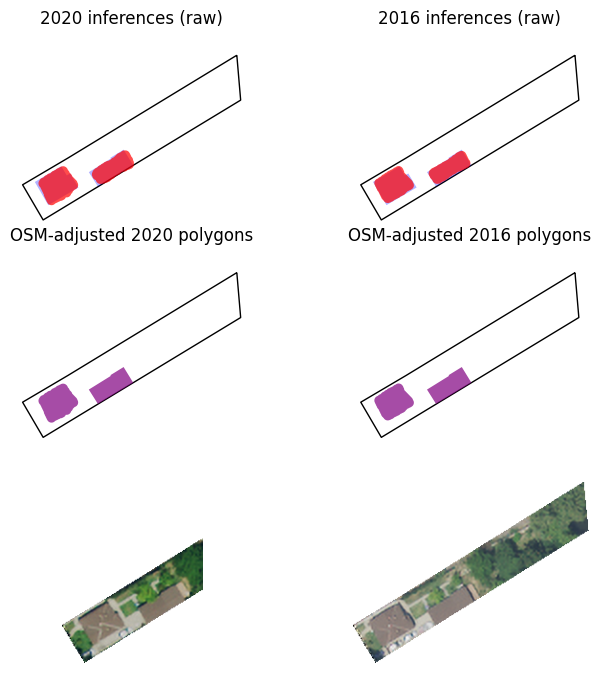

{'2016':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.895222   
 1               False      True          0.909258   
 
                                             geometry        area  
 0  POLYGON ((-121.87464 37.34788, -121.87464 37.3...  104.307377  
 1  POLYGON ((-121.87444 37.34792, -121.87435 37.3...   84.321316  ,
 '2020':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.837494   
 1               False      True          0.873529   
 
                                             geometry        area  
 0  POLYGON ((-121.87463 37.34788, -121.87463 37.3...  111.886797  
 1  POLYGON ((-121.87444 37.34792, -121.87435 37.3...   84.321316  }

In [112]:
plot_processed_parcel(
    parcel_apn='46705040', 
    model_params={'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0},
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
                 'tiles_gdf': tiles_gdf})

## Parcel-level confidence

In [24]:
# We have non-null confidence values for 267/1000 parcels
CF_parcel_conf = pd.read_csv('POP-parcel-conf.csv')
CF_parcel_conf.drop_duplicates(subset='APN', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951 entries, 0 to 998
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   APN         951 non-null    object 
 1   confidence  267 non-null    float64
dtypes: float64(1), object(1)
memory usage: 22.3+ KB
None


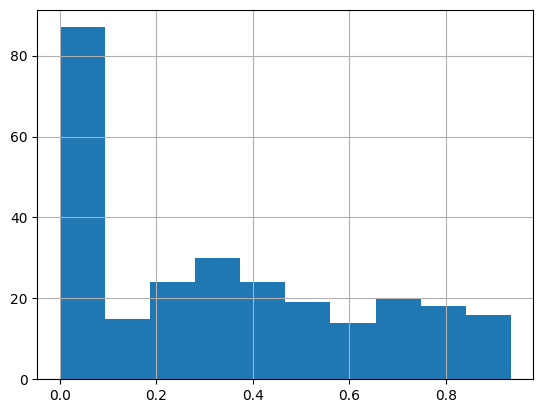

In [25]:
print(CF_parcel_conf.info())
CF_parcel_conf['confidence'].hist()
plt.show()

In [64]:
# Compute parcel-level precision
# * True and false positives (predicted)
parcel_accuracy = gpd.GeoDataFrame()
for year in ['2016', '2020']:
    builds = CF_buildings[year].copy()
    builds['year'] = year
    parcel_accuracy = pd.concat([parcel_accuracy, builds])
    
parcel_accuracy.rename(columns={'true_positive': 'accuracy'}, inplace=True)
parcel_accuracy = parcel_accuracy[['accuracy', 'year', 'geometry']]

In [65]:
# * Add false negatives
# Note that this either adds a building over which to aggregate temporally/spatially if 
# the model predicted other small buildings in the parcel, or assigns an accuracy of 0 
# to the parcel if the model did not predict any small buildings here. 
fn = CF_LABELS.loc[(CF_LABELS['label'] == 'building_missed_by_model') & (CF_LABELS['year'] != 2018)].copy()
fn['accuracy'] = 0

parcel_accuracy = pd.concat(
    [parcel_accuracy, fn[['accuracy', 'year', 'geometry']]])

In [66]:
# * Assign to parcels
parcel_accuracy = parcel_accuracy.sjoin(
    CF_parcels[['APN', 'geometry']], how='left', predicate='intersects')

In [67]:
# * Aggregate at the parcel-level (computes mean accuracy across buildings and time for a parcel)
parcel_accuracy.dropna(subset=['APN'], inplace=True)
parcel_accuracy = parcel_accuracy.groupby('APN')['accuracy'].mean().reset_index()

In [68]:
# * Add true negative parcels
tn = CF_parcels.loc[~CF_parcels['APN'].isin(parcel_accuracy['APN'].unique())]
tn['accuracy'] = 1
parcel_accuracy = pd.concat([parcel_accuracy, tn[['APN', 'accuracy']]])

In [69]:
# Note we have two duplicated APNs (with the same accuracy), which we drop
parcel_accuracy = parcel_accuracy.loc[~parcel_accuracy.duplicated(subset=['APN'])]

In [70]:
# * Add parcel-level confidence
parcel_accuracy = pd.merge(parcel_accuracy, CF_parcel_conf, how='left', validate='one_to_one')

In [71]:
parcel_accuracy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 996
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   APN         997 non-null    object 
 1   accuracy    997 non-null    float64
 2   confidence  267 non-null    float64
dtypes: float64(2), object(1)
memory usage: 31.2+ KB


In [34]:
# Confidence - accuracy
# Note: only 151/1000 parcels had small buildings 

# Bin by confidence and compute average accuracy 
parcel_accuracy['bin'] = pd.cut(parcel_accuracy['confidence'], bins=2, labels=False)

parcel_accuracy['bin'] = parcel_accuracy['bin'].fillna(value= -1)

avg_accuracy = parcel_accuracy.groupby('bin')['accuracy', 'confidence'].mean().reset_index()

In [35]:
parcel_accuracy.groupby('bin')['accuracy'].count().reset_index()

,bin,accuracy
0,-1.0,730
1,0.0,180
2,1.0,87


In [36]:
avg_accuracy['bin_name'] = avg_accuracy['bin'].apply(
    lambda bin: 'Empty parcels' if bin == -1 else 'Low confidence' if bin == 0 else 'High confidence'
)

In [37]:
avg_accuracy

,bin,accuracy,confidence,bin_name
0,-1.0,0.971918,NaN,Empty parcels
1,0.0,0.568214,0.155325,Low confidence
2,1.0,0.839080,0.695163,High confidence


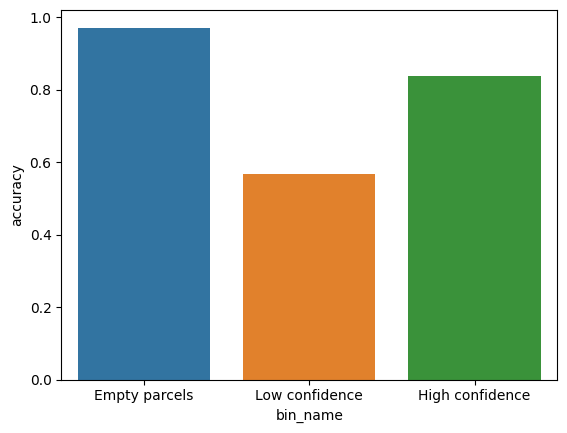

In [38]:
sns.barplot(avg_accuracy, x='bin_name', y='accuracy')
plt.show()

# 3. Design CF input

In [90]:
model_params = {'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0}

In [91]:
def generate_CF_input(parcel_apn, model_params, sat_imagery, title=True):
    # Collect parcel data
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # Prepare data
    inferred_buildings_parcel = {'2016': inferred_buildings_2016_parcel,
                                 '2020': inferred_buildings_2020_parcel}
    
    osm_buildings_parcel = {'2016': osm_buildings_parcel,
                            '2020': osm_buildings_parcel}
    print('[INFO] OSM HISTORIC DATA NOT YET INCORPORATED')
    
    # Incorporate OSM data
    parcel_buildings, _ = process_parcel_buildings(
        inferred_buildings_parcel, osm_buildings_parcel, parcel_bounds, model_params)
    
    # Define axis 
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))

    # Get individual axis
    ax1, ax2 = axs

    for ax in axs:
        ax.axis('off')

    # Add titles
    if title:
        ax1.set_title('2020')
        ax2.set_title('2016')


    for year, ax in zip(['2020', '2016'], (ax1, ax2)):
        # * NAIP
        # Add buffer to parcel_bounds to get neighborhood/street context
        parcel_bounds_buffered = parcel_bounds.copy()
        parcel_bounds_buffered['geometry'] = parcel_bounds.to_crs('EPSG:26910').buffer(10)

        # Get imagery
        file_name = get_file_name_from_parcel(
            parcel_apn, sat_imagery['sj_parcels_res'], sat_imagery['tiles_gdf'][year])
        img_file, superres_file = find_image_file_and_superrestile(
            sat_imagery['img_fp'][year], sat_imagery['tif_fp'][year], file_name)

        with rasterio.open(superres_file) as src:
            out_image, out_transform = rasterio.mask.mask(
                src, parcel_bounds_buffered.to_crs('EPSG:26910')['geometry'], crop=True, nodata=255)

        # Plot
        rasterio.plot.show(out_image, transform=out_transform, ax=ax, alpha=1)

        ax.axis('off')
        # * Output
        output_year = parcel_buildings[year].copy()
        if output_year is not None:
            output_year = output_year.loc[output_year['main_building_flag'] == False]
            output_year.geometry = output_year.geometry.exterior
            output_year.to_crs('EPSG:26910').plot(ax=ax, color='red')

        # * Parcel outline
        parcel_bounds.to_crs('EPSG:26910').plot(
            ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)

    plt.show()
    
    return parcel_buildings

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


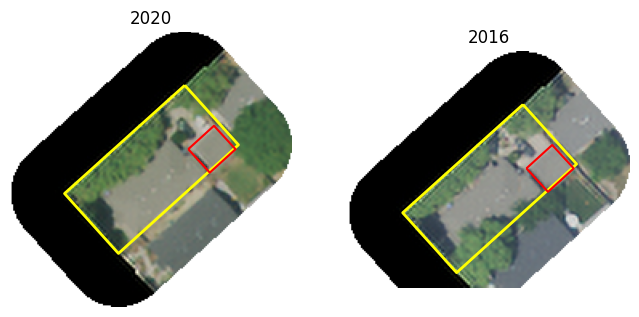

{'2016':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.671434   
 1               False      True          0.902141   
 
                                             geometry        area  
 0  POLYGON ((-121.92103 37.34371, -121.92103 37.3...  145.360342  
 1  POLYGON ((-121.92084 37.34380, -121.92079 37.3...   38.872002  ,
 '2020':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.805904   
 1               False      True          0.953307   
 
                                             geometry        area  
 0  POLYGON ((-121.92102 37.34372, -121.92102 37.3...  172.592401  
 1  POLYGON ((-121.92084 37.34380, -121.92079 37.3...   38.872002  }

In [92]:
generate_CF_input(parcel_apn='23041017', 
                  model_params=model_params, 
                  sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
                 'tiles_gdf': tiles_gdf})

### Debug plotting

In [7]:
parcel_apn='23041017'
model_params=model_params
sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
             'tiles_gdf': tiles_gdf}
title=True
# Collect parcel data
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

# Prepare data
inferred_buildings_parcel = {'2016': inferred_buildings_2016_parcel,
                             '2020': inferred_buildings_2020_parcel}

osm_buildings_parcel = {'2016': osm_buildings_parcel,
                        '2020': osm_buildings_parcel}
print('[INFO] OSM HISTORIC DATA NOT YET INCORPORATED')

# Incorporate OSM data
parcel_buildings, _ = process_parcel_buildings(
    inferred_buildings_parcel, osm_buildings_parcel, parcel_bounds, model_params)

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


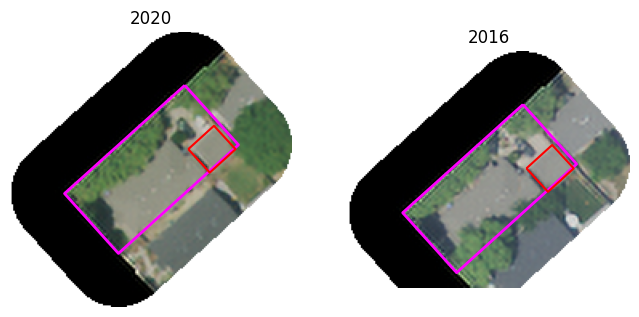

In [49]:
# Define axis 
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))

# Get individual axis
ax1, ax2 = axs

for ax in axs:
    ax.axis('off')

# Add titles
if title:
    ax1.set_title('2020')
    ax2.set_title('2016')


for year, ax in zip(['2020', '2016'], (ax1, ax2)):
    # * NAIP
    # Add buffer to parcel_bounds to get neighborhood/street context
    parcel_bounds_buffered = parcel_bounds.copy()
    parcel_bounds_buffered['geometry'] = parcel_bounds.to_crs('EPSG:26910').buffer(10)

    # Get imagery
    file_name = get_file_name_from_parcel(
        parcel_apn, sat_imagery['sj_parcels_res'], sat_imagery['tiles_gdf'][year])
    img_file, superres_file = find_image_file_and_superrestile(
        sat_imagery['img_fp'][year], sat_imagery['tif_fp'][year], file_name)

    with rasterio.open(superres_file) as src:
        out_image, out_transform = rasterio.mask.mask(
            src, parcel_bounds_buffered.to_crs('EPSG:26910')['geometry'], crop=True, nodata=255)

    # Plot
    rasterio.plot.show(out_image, transform=out_transform, ax=ax, alpha=1)

    ax.axis('off')
    # * Output
    output_year = parcel_buildings[year].copy()
    if output_year is not None:
        output_year = output_year.loc[output_year['main_building_flag'] == False]
        output_year.geometry = output_year.geometry.exterior
        output_year.to_crs('EPSG:26910').plot(ax=ax, color='red')
        
    # * Parcel outline
    parcel_bounds.to_crs('EPSG:26910').plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=2)

plt.show()

# 4. Define strata
Shapefiles include 643 CBGs as of 2016 for San Jose. ACS has non-missing data for 628 CBGs.

Define strata, and which CBGs belong to high/low income regions.

In [88]:
# Filter for SJ CBGs
cbg_income_2016 = cbg_income_2016.loc[cbg_income_2016['GEOID'].isin(cbg_sj_2016['GEOID'].unique())]

In [89]:
cbg_income_2016.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 643 entries, 4 to 1070
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     643 non-null    object  
 1   hh_mdn_   628 non-null    float64 
 2   geometry  643 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 20.1+ KB


In [301]:
cbg_income_2016.loc[~cbg_income_2016['GEOID'].isin(cbg_sj_2016['GEOID'])]['GEOID'].unique()

array(['060855006004', '060855008003', '060855009013', '060855015023',
       '060855016011', '060855016012', '060855016021', '060855016022',
       '060855016023', '060855019011', '060855019021', '060855019022',
       '060855021031', '060855021032', '060855021041', '060855021042',
       '060855022031', '060855022032', '060855022041', '060855022042',
       '060855027033', '060855027041', '060855027043', '060855031123',
       '060855031163', '060855031213', '060855031241', '060855031242',
       '060855031243', '060855031251', '060855031252', '060855031261',
       '060855031271', '060855031272', '060855032183', '060855032191',
       '060855032192', '060855032201', '060855032202', '060855032203',
       '060855032211', '060855032221', '060855032222', '060855033154',
       '060855033381', '060855033382', '060855033391', '060855033392',
       '060855035083', '060855037123', '060855038033', '060855040023',
       '060855043114', '060855043194', '060855050063', '060855050064',
      

In [298]:
cbg_sj_2016.loc[cbg_sj_2016['mean_income'].isna()]['GEOID'].unique()

array(['060855122001', '060855123051', '060855123111', '060855123083',
       '060855121001', '060855119113', '060855135001', '060855120331',
       '060855120334', '060855035045', '060855035072', '060855033222',
       '060855035093', '060855033122', '060855120333', '060855120332',
       '060855120202', '060855120173', '060855120201', '060855120171',
       '060855033341', '060855120172', '060855120203', '060855033324',
       '060855033343', '060855033342', '060855041022', '060855041023',
       '060855041012', '060855039022', '060855039023', '060855039021',
       '060855042013', '060855042022', '060855042012', '060855038024',
       '060855042021', '060855042011', '060855043081', '060855043163',
       '060855045053', '060855044162', '060855044161', '060855045044',
       '060855044151', '060855044171', '060855013004', '060855037033',
       '060855002002', '060855037082', '060855031083', '060855031082',
       '060855032043', '060855032044', '060855032042', '060855031081',
      

In [ ]:
# Stratify
np.percentile()

Assign parcels to CBGs

Compute an estimate for N_H = number of parcels in each income strata / confidence bin

# 5. Power Analysis

## Use CF annotations as estimates

In [242]:
# Convert CF labels to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

In [39]:
# * Assign to CBGs
cf_cbgs = CF_LABELS.sjoin(cbg_sj_2016[['GEOID', 'geometry']], how='left', predicate='intersects')

# Check all points are assigned to a single CBG
assert len(cf_cbgs) == len(CF_LABELS)

In [40]:
cf_cbgs = cf_cbgs.groupby(['year'])['GEOID'].unique()

In [41]:
# We have annotations in 200 CBGs for 2020 and 171 CBGs for 2016 out of 643 CBGs
len(cf_cbgs[2016])

171

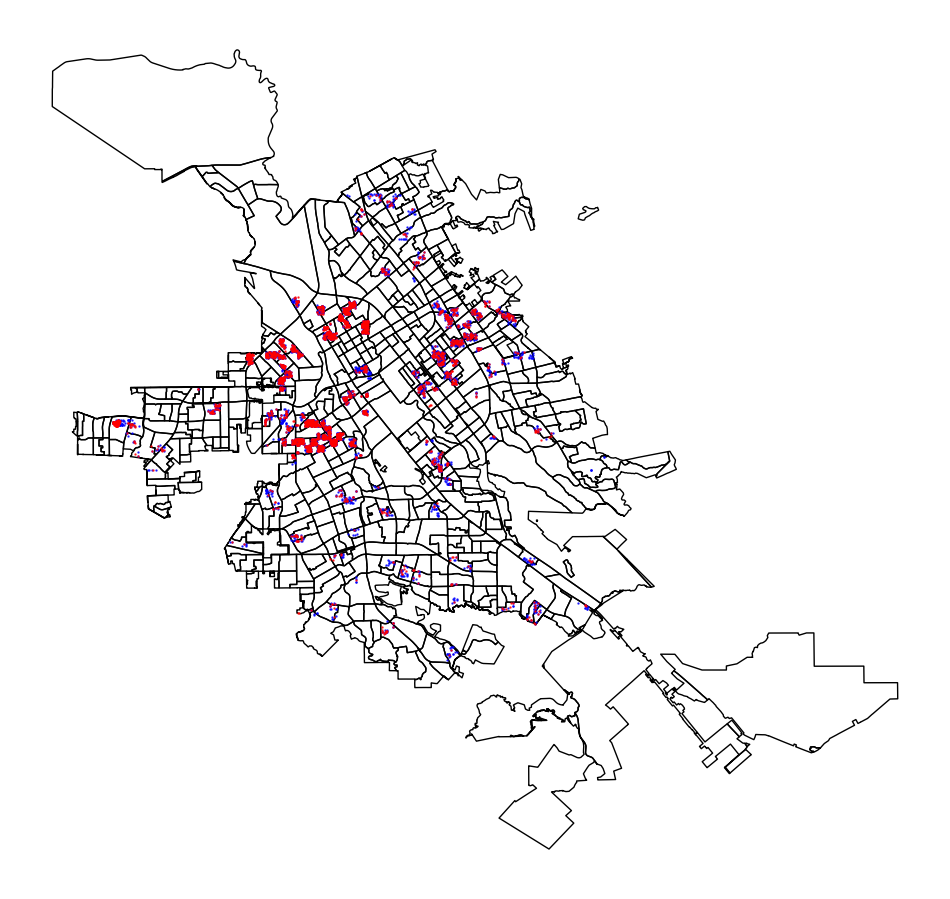

In [43]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

cbg_sj_2016.plot(ax=ax, facecolor='none', edgecolor='black')
#CF_area_coverage.plot(ax=ax, color='green')
CF_LABELS.loc[CF_LABELS['year'] == 2020].plot(ax=ax, alpha=0.8, marker='.', markersize=2, color='blue')
CF_LABELS.loc[CF_LABELS['year'] == 2016].plot(ax=ax, alpha=0.8, marker='.', markersize=2, color='red')
plt.show()

In [ ]:
# CBG-level small building density and income (generated in part 1 of this notebook) -- 
# for CBGs per 2016 shp
cbg_density_path = 'cbg_density.csv'
cbg_data = pd.read_csv(cbg_density_path)

In [ ]:
# Classify cbgs into high-low income neighborhoods

N1 = None
N2 = None

In [ ]:
# Compute CBG density mean and SEs to define effect size
d = None

In [ ]:
# Power analysis
alpha = 0.5
power = 0.8

ttest = TTestIndPower()
n = ttest.solve_power(
    effect_size=d, alpha=alpha, power=power, nobs=N1
    ratio=N2/N1, alternative='two-sided')